In [14]:
%run "part03_data_preparation.ipynb"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
 8   Unnamed: 8   0 non-null       float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [15]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy

from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors

from itertools import combinations
from plotly.offline import plot, iplot, init_notebook_mode
from plotly import express as px
from plotly.subplots import make_subplots
import plotly as py
import plotly.graph_objs as go

**Content**

* **Modeling**
    - Kmeans
        - Elbow Method, Silhouette Score
    - Hierarchical Clustering
        - Dendogram 
    - Gaussian Mixture Model
        - AIC, BIC
    - DBScan
        - KNN

* **Embedded Space** 

# Modeling

In [9]:
# Setting 2D plot parameters for Plotly
temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12)))

def plot_graph2D(x,y, cluster, title):    
    
    #data=data.sort_values(by=cluster.name, ascending=True)
    cluster=cluster.astype(str)
    
    fig = px.scatter(#data, 
                     x=x, 
                     y=y, 
                     color=cluster, 
                     color_discrete_sequence=px.colors.qualitative.Prism
                    )

    fig.update_traces(marker=dict(size=11, 
                              opacity=0.75, 
                              line=dict(width=1, color='#F7F7F7')))

    fig.update_layout(template=temp, 
                  title=title, 
                  width=700, 
                  legend_title='Cluster',                  
                  xaxis=dict(title='x', showline=True, zeroline=False), 
                  yaxis=dict(title='y',showline=True, zeroline=False))
    fig.show()

## Kmeans

In [10]:
# Finding best K param to Kmeans, using WCSS and Silhouette Score as metrics
kmeans_scores_list = []

for k in range(2,13):
    tunning_kmeans = KMeans(n_clusters=k, random_state=3456)# init="k-means++",       
    tunning_kmeans_labels = tunning_kmeans.fit_predict(X)
    
    ss = silhouette_score(X, tunning_kmeans_labels, metric='euclidean')
    
    kmeans_scores_list.append(pd.Series({'Clusters': k,
                                    'WCSS': tunning_kmeans.inertia_,
                                    'SS': ss}))

In [11]:
kmeans_scores_table = (pd.concat(kmeans_scores_list, axis=1).T
           [['Clusters','WCSS','SS']]
           .set_index('Clusters'))

In [12]:
plt.figure(figsize=(10,5))
elbow = KElbowVisualizer(kmeans, k=(2,12), timings = False)
elbow.fit(X) #, timings = False
elbow.show();

NameError: name 'kmeans' is not defined

<Figure size 720x360 with 0 Axes>

In [13]:
clusters_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4316 entries, 17850 to 12713
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GrossRevenueTotal  4316 non-null   float64
 1   RecencyDays        4316 non-null   float64
 2   Frequency          4316 non-null   float64
 3   umap_x             4316 non-null   float32
 4   umap_y             4316 non-null   float32
 5   tsne_x             4316 non-null   float32
 6   tsne_y             4316 non-null   float32
dtypes: float32(4), float64(3)
memory usage: 202.3 KB


In [13]:
# Using the best k find to our purpouse
k=10
kmeans = KMeans( n_clusters=k, random_state=3456)#init = "k-means++",
kmeans_labels = kmeans.fit_predict(X)
clusters_results['KMeans-Cluster'] = kmeans_labels

C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



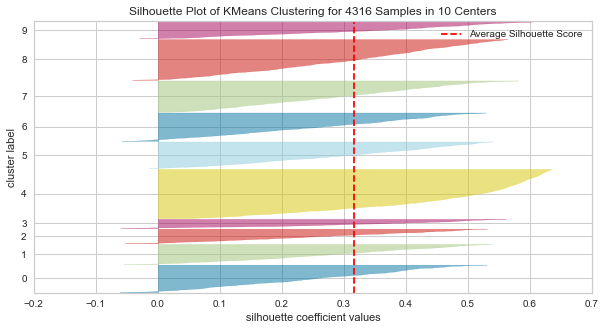

In [14]:
plt.figure(figsize=(10,5))
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

In [15]:
#clusters_results.sort_values(by='KMeans-Cluster')

plot_graph2D(clusters_results['umap_x'],
             clusters_results['umap_y'],
             clusters_results['KMeans-Cluster'],
             title='KMeans Cluster using UMAP')

plot_graph2D(clusters_results['tsne_x'],
             clusters_results['tsne_y'],
             clusters_results['KMeans-Cluster'],
             title='KMeans Cluster using t-SNE')

### Hierarchical Clustering

C:\Users\Alysson\AppData\Local\Temp/ipykernel_7896/4026379722.py:21: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



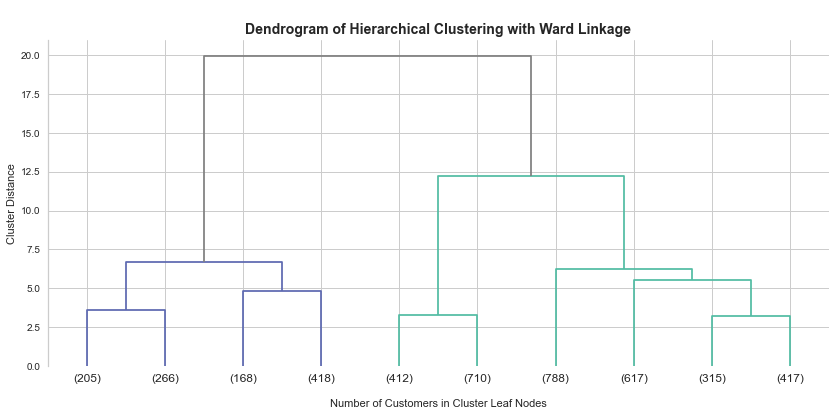

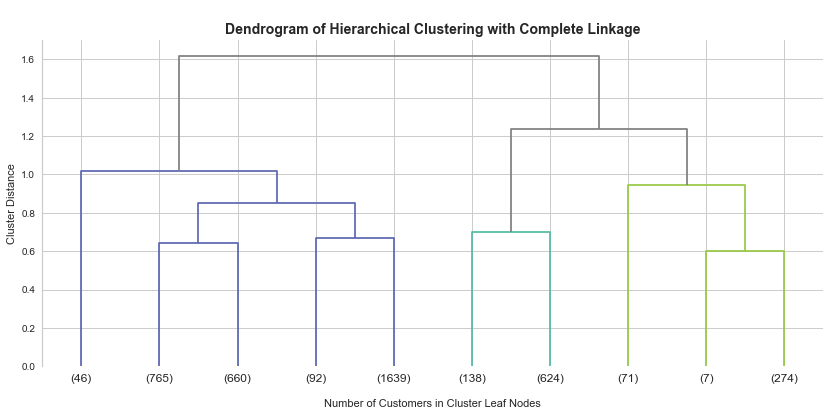

In [16]:
# Finding best K param to Hierachical Clustering, using Dendogram as metric
methods=['ward','complete']

for i in methods:
    Z = hierarchy.linkage(X, method=i, metric='euclidean')
    hierarchy.set_link_color_palette(['#5d69b1', '#52bca3', '#99c945'])

    fig, ax = plt.subplots(figsize=(14,6))
    den=hierarchy.dendrogram(Z, 
                             p=10, 
                             truncate_mode='lastp',
                             show_leaf_counts=True, 
                             ax=ax,
                             above_threshold_color='grey') #orientation='top', #color_threshold=100,
    
    #ax.axhline(10, color='grey', linestyle='--')
    ax.set_title(f'\nDendrogram of Hierarchical Clustering with {i.capitalize()} Linkage', fontweight='bold', fontsize='14')
    ax.set_xlabel('\nNumber of Customers in Cluster Leaf Nodes')
    ax.set_ylabel('Cluster Distance')
    ax.spines['right'].set_visible(False), ax.spines['top'].set_visible(False), ax.spines['bottom'].set_visible(False)
    fig.show()

In [17]:
# Using the best k find to our purpouse

k=10
#hc = AgglomerativeClustering(k, affinity='euclidean', linkage='complete', compute_full_tree=False)
hc = hierarchy.linkage(X, 'ward', metric='euclidean')
hc_labels = hierarchy.fcluster(hc, k, criterion='maxclust')
clusters_results["HierarchicalCluster"]=hc_labels

In [262]:
plot_graph2D(clusters_results['umap_x'],
             clusters_results['umap_y'],
             clusters_results['HierarchicalCluster'],
             title='Hierarchical Cluster using UMAP')

plot_graph2D(clusters_results['tsne_x'],
             clusters_results['tsne_y'],
             clusters_results['HierarchicalCluster'],
             title='Hierarchical Cluster using t-SNE')

In [19]:
# clusters_results.sort_values(by='HierarchicalCluster')

# fig = px.scatter(clusters_results, x="RecencyDays", y="GrossRevenueTotal", color="HierarchicalCluster", 
#                  color_discrete_sequence=px.colors.qualitative.Prism)
# fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
# fig.update_layout(template=temp, title="Hierarchical Cluster Profiles", 
#                   width=700, legend_title='Cluster',
#                   xaxis=dict(title='RecencyDays', showline=True, zeroline=True), 
#                   yaxis=dict(title='GrossRevenueTotal',showline=True))
# fig.show()

### Guassian Mistured Model

In [20]:
# Finding best K param to GMM, AIC and BIC as metrics
gmm_scores_list = []

for k in range(2,13):
    tunning_gmm = GaussianMixture(n_components=k, random_state=3456)#n_init=5, init_params='k-means++', 
    tunning_gmm_labels = tunning_gmm.fit_predict(X)
    
    ss = silhouette_score(X, tunning_gmm_labels, metric='euclidean')
    
    gmm_scores_list.append(pd.Series({'Clusters': k,
                                    'AIC': tunning_gmm.aic(X),
                                    'BIC': tunning_gmm.bic(X),
                                    'SS': ss}))
    
gmm_scores_table = (pd.concat(gmm_scores_list, axis=1).T[['Clusters','AIC','BIC','SS']])#.set_index('Clusters'))    

In [21]:
gmm_scores_table

Clusters           AIC           BIC        SS
0        2.0 -28431.961364 -28310.929762  0.236888
1        3.0 -29271.953052 -29087.220607  0.214390
2        4.0 -29874.339990 -29625.906701  0.211065
3        5.0 -35224.255870 -34912.121738  0.112137
4        6.0 -35298.948130 -34923.113155  0.117084
5        7.0 -40422.290935 -39982.755117  0.066886
6        8.0 -38501.432816 -37998.196154  0.010454
7        9.0 -35956.750802 -35389.813297  0.135996
8       10.0 -40654.629189 -40023.990841  0.008126
9       11.0 -40657.424976 -39963.085785 -0.029252
10      12.0 -42474.652281 -41716.612247  0.064385

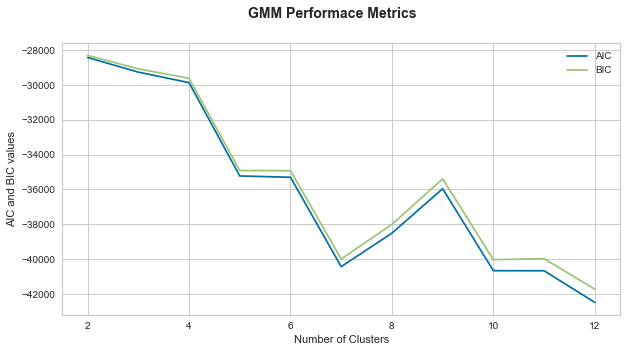

In [22]:
plt.figure(figsize=(10,5))
plt.suptitle('GMM Performace Metrics', fontsize=14, fontweight='bold')
plt.plot(gmm_scores_table.Clusters, gmm_scores_table.AIC, label='AIC')
plt.plot(gmm_scores_table.Clusters, gmm_scores_table.BIC, label='BIC')
plt.ylabel('AIC and BIC values')
plt.xlabel('Number of Clusters')
plt.legend(loc='best')
plt.show()

In [23]:
k=9
gmm = GaussianMixture(n_components=k, random_state=3456)#n_init=5, init_params='k-means++',
gmm_labels = gmm.fit_predict(X)
clusters_results['GMM-Cluster'] = gmm_labels

In [24]:
#clusters_results.sort_values(by='GMM-Cluster')
plot_graph2D(clusters_results['umap_x'],
             clusters_results['umap_y'],
             clusters_results['GMM-Cluster'],
             title='GMM Cluster using UMAP')

plot_graph2D(clusters_results['tsne_x'],
             clusters_results['tsne_y'],
             clusters_results['GMM-Cluster'],
             title='GMM Cluster using t-SNE')

### DBScan

In [25]:
# Using to find outliers
# As our data is very homogeneous, it might not perform well as a classifier, however DBScan is a great algorithm to detect outliers.
eps=0.048
min_samples=7

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)

clusters_results['DBScan-Cluster'] = dbscan_labels
clusters_results['DBScan-Cluster'] = clusters_results['DBScan-Cluster'].astype(str).apply(lambda x: 'Outlier' if x == '-1' else x)
clusters_results['DBScan-Cluster'].value_counts()

0          1488
2          1420
3           767
Outlier     286
1           217
4            56
5            40
9            19
7             8
8             8
6             7
Name: DBScan-Cluster, dtype: int64

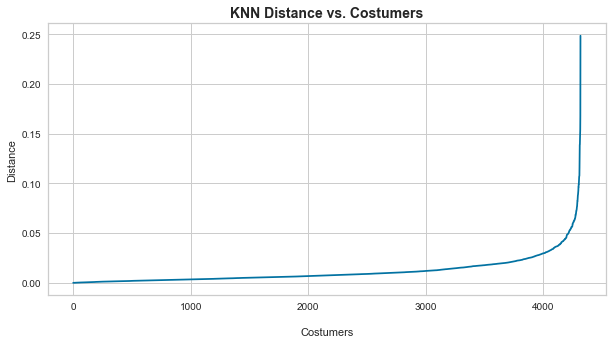

In [26]:
# Finding best epsilon(radious) param to DBScan, AIC and BIC as metrics

knn = NearestNeighbors(n_neighbors=min_samples).fit(X)
distance, costumers = knn.kneighbors(X)
distance = np.sort(distance, axis=0)
distance = distance[:,1]

plt.figure(figsize=(10,5))
plt.title("KNN Distance vs. Costumers", fontweight='bold', fontsize=14)
plt.xlabel('\nCostumers')
plt.ylabel('Distance')
plt.plot(distance);
#best eps is around 0.04~0.05

In [27]:
plot_graph2D(clusters_results['umap_x'],
             clusters_results['umap_y'],
             clusters_results['DBScan-Cluster'],
             title='DBScan Cluster using UMAP')

plot_graph2D(clusters_results['tsne_x'],
             clusters_results['tsne_y'],
             clusters_results['DBScan-Cluster'],
             title='DBScan Cluster using t-SNE')

In [28]:
#clusters_results.sort_values(by='GrossRevenueTotal', ascending=False).tail(50)

In [265]:
# Initializing figure with 3 3D subplots
fig = make_subplots(rows=1, cols=1,
                    specs=[[{'type': 'scatter3d'}]])
                  

# Adding clusters to scatterplots 
clusters_results['HierarchicalCluster'] = clusters_results['HierarchicalCluster'].astype(int)
clusters_results = clusters_results.sort_values(by='HierarchicalCluster')  

for i in range(0,8):
    fig.add_trace(go.Scatter3d(x = clusters_results[clusters_results['HierarchicalCluster'] == i]['RecencyDays'],
                               y = clusters_results[clusters_results['HierarchicalCluster'] == i]['Frequency'],
                               z = clusters_results[clusters_results['HierarchicalCluster'] == i]['GrossRevenueTotal'],                        
                               mode = 'markers', marker=dict(
                                   size=7,  
                                   color = px.colors.qualitative.Prism[i],
                                   line_width = 1,
                                   line_color='#F7F7F7',
                                   opacity=0.7),                               
                               name = str('Cluster '+str(i)), legendgroup = 1),                                                               
                 row=1, col=1)
    
fig.update_traces(hovertemplate='x: %{x} <br>y: %{y} <br>z: %{z}')

fig.update_layout(title="HC Clusterization",
                  template=temp, height=700, legend_tracegroupgap = 550,
                  scene=dict(aspectmode='cube',
                             xaxis = dict(title='RecencyDays', 
                                          backgroundcolor="#F3F3F3",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white",),
                             yaxis = dict(title='Frequency',
                                          backgroundcolor="#E4E4E4",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white"),
                             zaxis = dict(title='GrossRevenueTotalZ', 
                                          backgroundcolor="#F6F6F6",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white")))  
fig.show()

## Embedding Space

In [53]:
X_prep = X.drop(columns=['GrossRevenueTotal'], axis=1)
y_prep = X['GrossRevenueTotal']

rf = RandomForestRegressor(n_estimators=100, random_state=3456)
rf.fit(X_prep,y_prep)

df_leaf_prep = pd.DataFrame(rf.apply(X_prep))
df_tree_prep = pd.DataFrame()

In [54]:
df_leaf_prep

0     1     2     3     4     5     6     7     8     9   ...    90  \
0     2260  2244  2254  2226  2256  2230  2225  2276  2244  2280  ...  2271   
1     1924  1866  1902  1906  1935  1863  1919  1926  1877  1911  ...  1937   
2     2073  2032  2084  2077  2091  2082  2066  2092  2097  2094  ...  2056   
3     1524  1563  1512  1557  1552  1525  1519  1528  1545  1540  ...  1554   
4     1207  1193  1191  1231  1225  1211  1209  1195  1213  1217  ...  1229   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
4311    14    10    12    12    13     7    10     8     8    10  ...     8   
4312    14    10    12    12    13     7    10     8     8    10  ...     8   
4313    14    10    12    12    13     7    10     8     8    10  ...     8   
4314    14    10    12    12    13     7    10     8     8    10  ...     8   
4315     7     5     5     7     5     7    10     7     8     8  ...     6   

        91    92    93    94    95    96    97    98    99  
0     2248  2236  2189  2309  2243  2258  2252  2257  2248  
1     1930  1868  1861  1930  1866  1906  1858  1916  1929  
2     2084  2072  2034  2017  2082  2019  2062  2022  2090  
3     1542  1545  1514  1580  1534  1513  1528  1566  1504  
4     1201  1231  1205  1460  1217  1229  1199  1231  1233  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
4311    15     8    11     8    13    10    10    11     7  
4312    15     8    11     8    13    10    10    11     7  
4313    15     8    11     8    13    10    10    11     7  
4314    15     8    11     8    13    10    10    11     7  
4315     6     7    11     8     5     8     6    11     7  

[4316 rows x 100 columns]

In [55]:
embedding_umap = umap.fit_transform(df_leaf_prep)

df_tree_prep['umap_em_x'] = embedding_umap[:, 0]
df_tree_prep['umap_em_y'] = embedding_umap[:, 1] 

C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

C:\Users\Alysson\anaconda3\lib\site-packages\umap\spectral.py:260: UserWarning:

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

C:\Users\Alysson\anaconda3\lib\site-packages\umap\spectral.py:260: UserWarning:

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!



In [56]:
#sns.scatterplot(x=df_tree_prep['umap_em_x'], y=df_tree_prep['umap_em_y']);

In [57]:
embedding_tsne = tsne.fit_transform(df_leaf_prep)

df_tree_prep['tsne_em_x'] = embedding_tsne[:, 0]
df_tree_prep['tsne_em_y'] = embedding_tsne[:, 1]

C:\Users\Alysson\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [40]:
#sns.scatterplot(x=df_tree_prep['tsne_em_x'],y=df_tree_prep['tsne_em_y']);

In [58]:
#embedding from UMAP (first run)
X_em = df_tree_prep[['umap_em_x','umap_em_y']].copy()
#X_em = df_tree_prep[['tsne_em_x','tsne_em_y']].copy()
#X_em = df_tree_prep[['umap_x','umap_y']].copy()
X_em.head()

umap_em_x  umap_em_y
0   5.245595   6.135498
1   9.004081  11.237100
2  -1.890089  -3.170998
3   9.920818  -6.329053
4   2.277760   2.134409

In [59]:
clusters_em = np.arange(2,21,1)

In [60]:
kmeans_list = []

for k in clusters_em:
    kmeans_em = KMeans(n_clusters=k, random_state=3456) #init="k-means++", 
    kmeans_em_labels = kmeans_em.fit_predict(X_em)
    kmeans_em_ss = silhouette_score(X_em, kmeans_em_labels, metric='euclidean')
    kmeans_list.append(kmeans_em_ss)

In [61]:
gmm_list = []
for k in clusters_em:
    gmm_em = GaussianMixture(n_components=k, random_state=3456) #n_init=10
    gmm_em_labels = gmm_em.fit_predict(X_em)    
    gmm_em_ss = silhouette_score(X_em, gmm_em_labels, metric='euclidean')
    gmm_list.append(gmm_em_ss)

In [62]:
hc_list = []
for k in clusters_em:
    hc_em = hierarchy.linkage(X_em, 'ward')
    hc_em_labels = hierarchy.fcluster(hc_em, k, criterion='maxclust')#to cut dendrogram    
    hc_ss = silhouette_score(X_em, hc_em_labels, metric='euclidean')
    hc_list.append(hc_ss) 

In [63]:
dbs_list = []
epsilon = np.arange(0.01, 1, 0.01)
for k in epsilon:
    dbs_em = DBSCAN(eps=k, min_samples=10, metric='euclidean')
    dbs_em_labels = dbs_em.fit_predict(X_em)   
    dbs_ss = silhouette_score(X_em, dbs_em_labels, metric='euclidean')
    dbs_list.append(dbs_ss) 

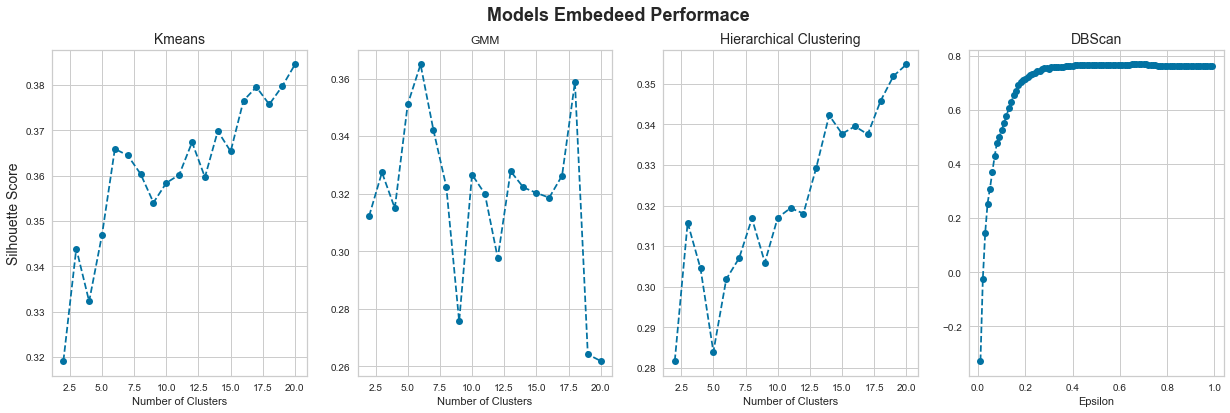

In [64]:
plt.figure(figsize=(21,6))
plt.suptitle("Models Embedeed Performace\n", fontweight='bold', fontsize=18)
# plt.supxlabel('Number of Clusters')
# plt.supylabel('Silhouette Score')
plt.subplot(1, 4, 1)
plt.plot(clusters_em, kmeans_list, linestyle='--', marker='o', color='b')
plt.title("Kmeans", fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.xlabel('Number of Clusters')
plt.subplot(1, 4, 2)
plt.title("GMM")
plt.xlabel('Number of Clusters')
plt.plot(clusters_em, gmm_list, linestyle='--', marker='o', color='b')
plt.subplot(1, 4, 3)
plt.title("Hierarchical Clustering", fontsize=14)
plt.xlabel('Number of Clusters')
plt.plot(clusters_em, hc_list, linestyle='--', marker='o', color='b')
plt.subplot(1, 4, 4)
plt.title("DBScan", fontsize=14)
plt.xlabel('Epsilon')
plt.plot(epsilon, dbs_list, linestyle='--', marker='o', color='b')
plt.show()

## Testing

In [65]:
# Kmeans
k=10
kmeans_em = KMeans(n_clusters=k, random_state=3456) #max_iter=300, init = "k-means++",
kmeans_em_labels = kmeans_em.fit_predict(X_em)
df_tree_prep['KMeans-Embeeded'] = kmeans_em_labels

In [66]:
k=10
gmm_em = GaussianMixture(n_components=k, n_init=5, init_params='k-means++', random_state=3456) #n_init=10
gmm_em_labels = gmm_em.fit_predict(X_em)  
df_tree_prep['GMM-Embeeded'] = gmm_em_labels

In [67]:
k=10
hc_em = hierarchy.linkage(X_em, 'ward')
hc_em_labels = hierarchy.fcluster(hc_em, k, criterion='maxclust') 
df_tree_prep['HC-Embeeded'] = hc_em_labels

In [68]:
# # Hierarchical clustering
# hc_em = AgglomerativeClustering(8, affinity='euclidean', linkage='complete', compute_full_tree=False)
# hc_em.fit(X_em)
# hc_em_labels = hc_em.labels_
# clusters_results['HC-Embeeded'] = hc_em_labels

In [69]:
eps=25
min_samples=15

dbs_em = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
dbs_em_labels = dbs_em.fit_predict(X_em)
df_tree_prep['DBScan-Embeeded'] = dbs_em_labels

<AxesSubplot:xlabel='umap_em_x', ylabel='umap_em_y'>

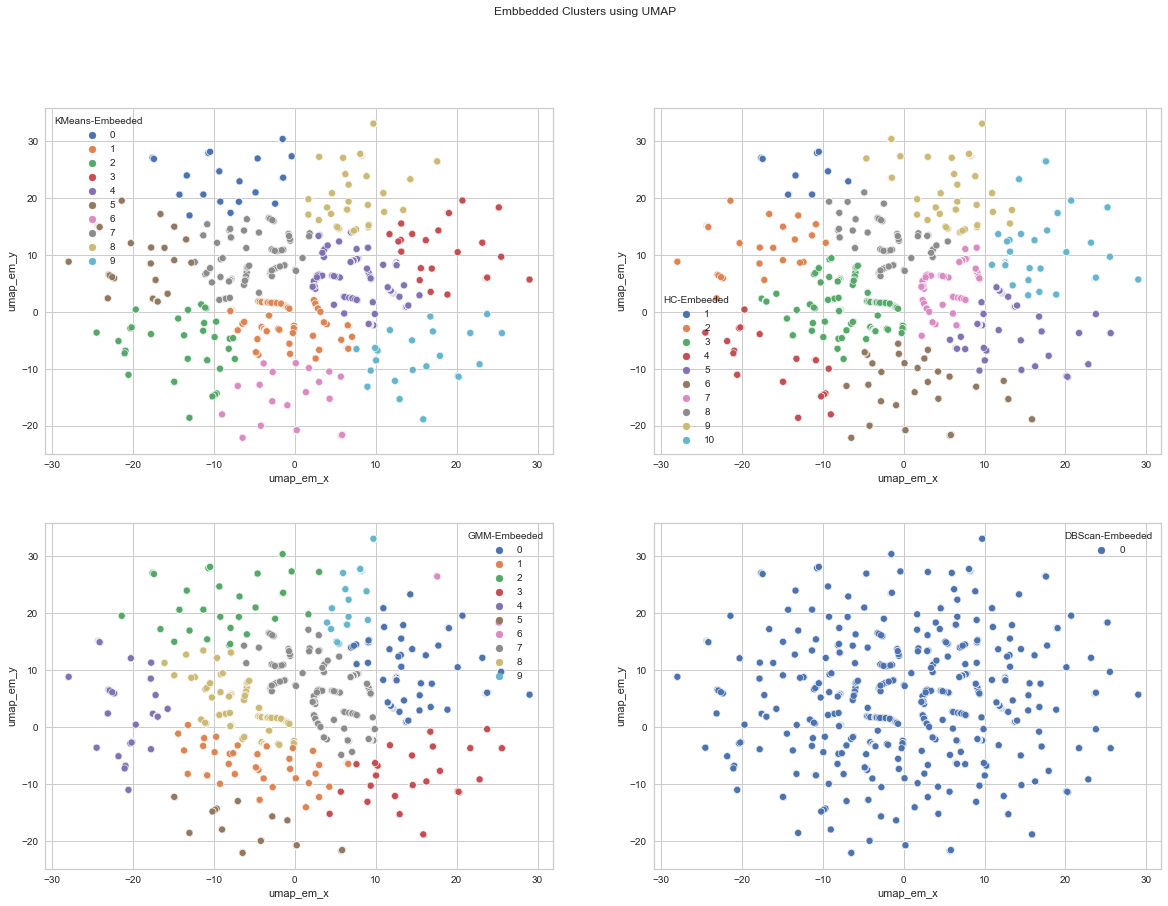

In [71]:
plt.figure(figsize=(20,14))
plt.suptitle('Embbedded Clusters using UMAP')
plt.subplot(2, 2, 1)
sns.scatterplot(x='umap_em_x', y='umap_em_y', hue='KMeans-Embeeded', data=df_tree_prep, palette='deep')
plt.subplot(2, 2, 2)
sns.scatterplot(x='umap_em_x', y='umap_em_y', hue='HC-Embeeded', data=df_tree_prep, palette='deep')
plt.subplot(2, 2, 3)
sns.scatterplot(x='umap_em_x', y='umap_em_y', hue='GMM-Embeeded', data=df_tree_prep, palette='deep')
plt.subplot(2, 2, 4)
sns.scatterplot(x='umap_em_x', y='umap_em_y', hue='DBScan-Embeeded', data=df_tree_prep, palette='deep')

<AxesSubplot:xlabel='tsne_em_x', ylabel='tsne_em_y'>

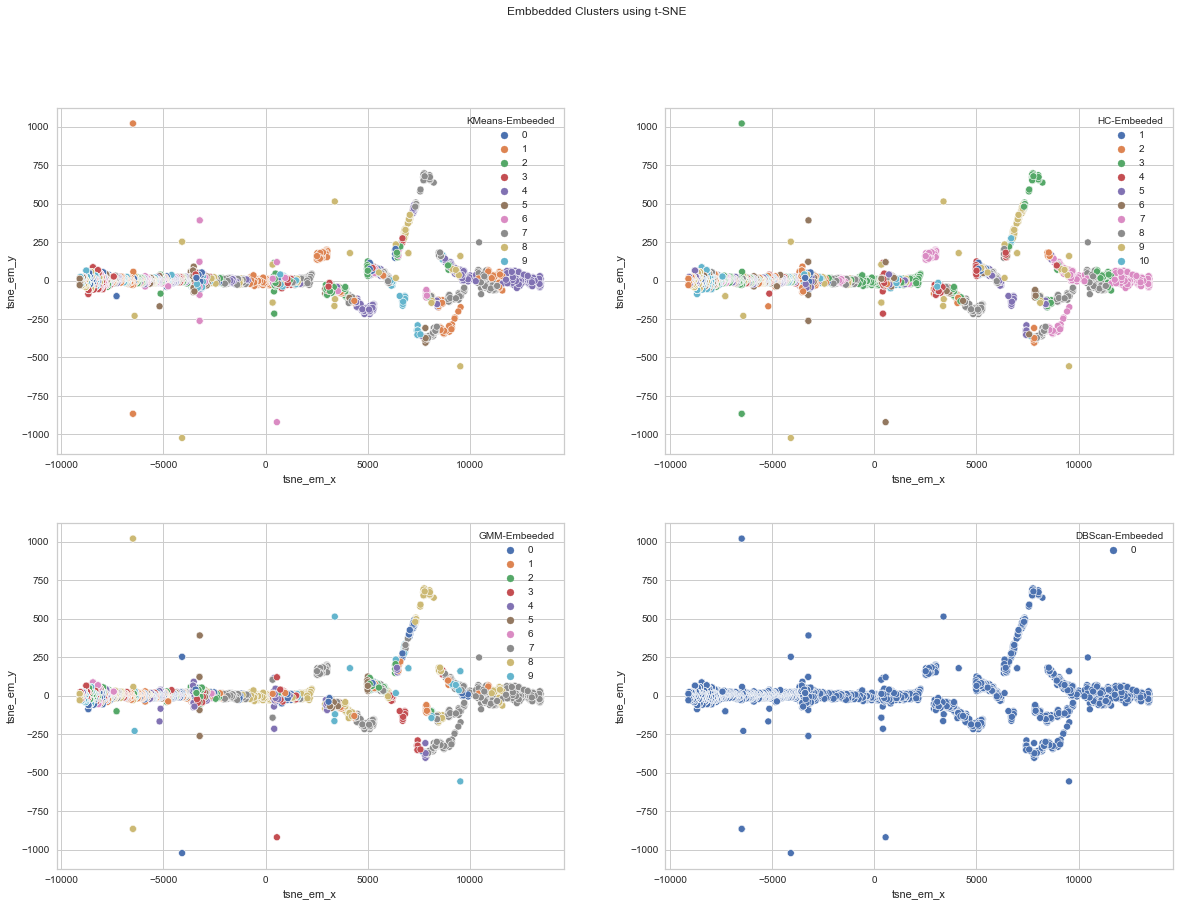

In [70]:
#TSNE Embedded

plt.figure(figsize=(20,14))
plt.suptitle('Embbedded Clusters using t-SNE')
plt.subplot(2, 2, 1)
sns.scatterplot(x='tsne_em_x', y='tsne_em_y', hue='KMeans-Embeeded', data=df_tree_prep, palette='deep')
plt.subplot(2, 2, 2)
sns.scatterplot(x='tsne_em_x', y='tsne_em_y', hue='HC-Embeeded', data=df_tree_prep, palette='deep')
plt.subplot(2, 2, 3)
sns.scatterplot(x='tsne_em_x', y='tsne_em_y', hue='GMM-Embeeded', data=df_tree_prep, palette='deep')
plt.subplot(2, 2, 4)
sns.scatterplot(x='tsne_em_x', y='tsne_em_y', hue='DBScan-Embeeded', data=df_tree_prep, palette='deep')

In [257]:
# knn = NearestNeighbors(n_neighbors=min_samples).fit(X)
# distance, costumers = knn.kneighbors(X)
# distance = np.sort(distance, axis=0)
# distance = distance[:,1]

# plt.figure(figsize=(10,5))
# plt.title("KNN Distance vs. Costumers", fontweight='bold', fontsize=14)
# plt.xlabel('\nCostumers')
# plt.ylabel('Distance')
# plt.plot(distance);
# #best eps is around 0.04~0.05

### Evaluating

In [259]:
#data_client_resume['Cluster'] = kmeans_em_labels
#data_client_resume['Cluster'] = hc_em_labels

In [72]:
all_clusters=data_client_resume.copy()


all_clusters['KM'] = kmeans_labels
all_clusters['KME'] = kmeans_em_labels

all_clusters['HC'] = hc_labels
all_clusters['HCE'] = hc_em_labels

all_clusters['GMM'] = gmm_labels
all_clusters['GMME'] = gmm_em_labels

all_clusters['DB'] = dbscan_labels
all_clusters['DBE'] = dbs_em_labels

In [247]:
all_clusters[['GrossRevenueTotal','RecencyDays','Frequency','HC']].groupby('HC').mean().sort_values(by='GrossRevenueTotal', ascending=False).head(20)

GrossRevenueTotal  RecencyDays  Frequency
HC                                           
3        19296.287560     4.232143  27.446429
4         4005.482871    15.255981   9.712919
1         2174.870683     3.614634   6.053659
7         1888.406574    73.011421   4.642132
9         1335.001714    23.907937   3.876190
5          730.574320   212.946602   2.303398
2          548.075526     7.917293   2.210526
10         417.530552    27.565947   1.695444
8          412.119643    72.048622   1.230146
6          236.495099   256.054930   1.002817

In [248]:
report = all_clusters[['GrossRevenueTotal','RecencyDays','Frequency','HC']].groupby('HC').agg( MonetarySum = ('GrossRevenueTotal', 'sum'),
                                             MonetaryMean = ('GrossRevenueTotal', 'mean'),
                                             Recency = ('RecencyDays', 'mean'),
                                             Frequency = ('Frequency', 'mean'),
                                             Count = ('GrossRevenueTotal', 'count')).reset_index()

report['Percentage'] = round((report['Count'] / report['Count'].sum()*100),2)

In [249]:
report.sort_values(by='MonetaryMean', ascending=False).head(20)

HC  MonetarySum  MonetaryMean     Recency  Frequency  Count  Percentage
2   3   3241776.31  19296.287560    4.232143  27.446429    168        3.89
3   4   1674291.84   4005.482871   15.255981   9.712919    418        9.68
0   1    445848.49   2174.870683    3.614634   6.053659    205        4.75
6   7   1488064.38   1888.406574   73.011421   4.642132    788       18.26
8   9    420525.54   1335.001714   23.907937   3.876190    315        7.30
4   5    300996.62    730.574320  212.946602   2.303398    412        9.55
1   2    145788.09    548.075526    7.917293   2.210526    266        6.16
9  10    174110.24    417.530552   27.565947   1.695444    417        9.66
7   8    254277.82    412.119643   72.048622   1.230146    617       14.30
5   6    167911.52    236.495099  256.054930   1.002817    710       16.45

In [250]:
report['Cluster'] = ['Champion', #3
                     'Loyal Costumer', #4
                     'Potential Loyalist',#1
                     'Need Atention', #7 
                     'Promising', #9
                     'At Risk', #5
                     'New Customers',    #2               
                     'Cannot Lose Them', #10
                     'About to Sleep',   #8
                     'Hinernating']   #6

In [251]:
data_client_resume['Segment']= hc_labels

In [252]:
hc_map = { 3:'Champions', 
           4:'Loyal Customers',
           1:'Potential Loyalists',
           7:'Cannot Lose Them', 
           9:'Promising',
           5:'At Risk',
           2:'New Customers',
           10:'Need Attention',
           8:'About to Sleep',
           6:'Hinernating'}

data_client_resume['Segment'].replace(hc_map, inplace=True)

In [254]:
rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                   "Loyal Customers": [3, 5, 0.4, 0.8],
                   "Cannot Lose Them": [4, 5, 0, 0.4],
                   "At Risk": [2, 4, 0, 0.4],
                   "Hinernating": [0, 2, 0, 0.4],
                   "About to Sleep": [0, 2, 0.4, 0.6],
                   "Promising": [0, 1, 0.6, 0.8],
                   "New Customers": [0, 1, 0.8, 1],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}

In [255]:
rfm=data_client_resume.copy()

In [257]:
rfm.groupby('Segment').mean().sort_values(by='GrossRevenueTotal', ascending=False).head(20)

GrossRevenueTotal  RecencyDays  Frequency
Segment                                                       
Champions                 19296.287560     4.232143  27.446429
Loyal Customers            4005.482871    15.255981   9.712919
Potential Loyalists        2174.870683     3.614634   6.053659
Cannot Lose Them           1888.406574    73.011421   4.642132
Promising                  1335.001714    23.907937   3.876190
At Risk                     730.574320   212.946602   2.303398
New Customers               548.075526     7.917293   2.210526
Need Attention              417.530552    27.565947   1.695444
About to Sleep              412.119643    72.048622   1.230146
Hinernating                 236.495099   256.054930   1.002817

In [258]:
rfm.groupby()

TypeError: You have to supply one of 'by' and 'level'

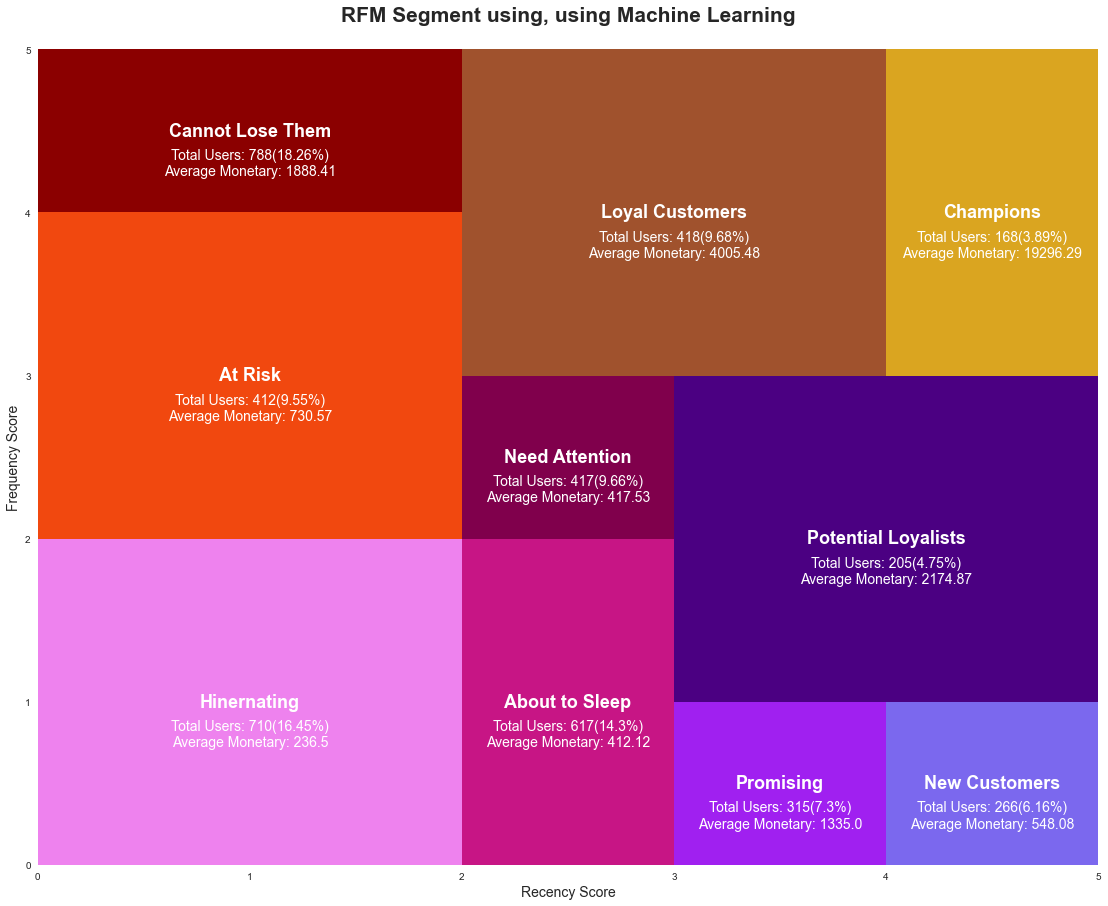

In [260]:
fig, ax = plt.subplots(figsize = (19, 15))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"] = "white"

palette = ["#DAA520", "#A0522D", "#8B0000", "#F1480F",  "#EE82EE", 
           "#C71585", "#A020F0", "#7B68EE", "#4B0082", "#80004C"]


#CD5C5C

for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]

    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)
    
    users = rfm[rfm.Segment == key].shape[0]
    users_percentage = (rfm[rfm.Segment == key].shape[0] / rfm.shape[0]) * 100
    avg_monetary = rfm[rfm.Segment == key]["GrossRevenueTotal"].mean()
    
    user_txt = "\n\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))
    
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
    plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    
    ax.set_xlabel("Recency Score", fontsize=14)
    ax.set_ylabel("Frequency Score", fontsize=14)
    
sns.despine(left = True, bottom = True)

plt.title('RFM Segment using, using Machine Learning\n', fontsize='21', fontweight='bold')
plt.savefig("..//images//rfm_ml.png")
plt.show()